In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/pack.zip'
extract_to = '/content/npz_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Files extracted to: {extract_to}')

Files extracted to: /content/npz_dataset


In [3]:
npz_directory = "/content/npz_dataset"  # Point to the extracted directory
visualization_output = "/content/visualizations"  # Save visualizations here

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from ipywidgets import interact, widgets
from IPython.display import display

npz_root = "/content/npz_dataset/pack/processed_data/ct_256/train/npz"
npz_files = sorted([f for f in os.listdir(npz_root) if f.endswith('.npz')])

# Grouping files by patients
from collections import defaultdict
patient_slices = defaultdict(list)
for f in npz_files:
    patient_id = f.split("_slice")[0]
    patient_slices[patient_id].append(f)

# Sorting slices for each patient
for pid in patient_slices:
    patient_slices[pid] = sorted(patient_slices[pid])

# Labels
label_map = {
    1: ("Left Ventricle Blood Cavity", 500),
    2: ("Right Ventricle Blood Cavity", 600),
    3: ("Left Atrium Blood Cavity", 420),
    4: ("Right Atrium Blood Cavity", 550),
    5: ("Myocardium", 205),
    6: ("Aorta", 820),
    7: ("Pulmonary Artery", 850)
}

def show_slice(patient_id, slice_idx):
    slice_file = patient_slices[patient_id][slice_idx]
    file_path = os.path.join(npz_root, slice_file)
    data = np.load(file_path)
    image, label = data['image'], data['label']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title(f"Image: {slice_file}")
    axs[0].axis('off')

    axs[1].imshow(image, cmap='gray')
    axs[1].imshow(label, cmap='nipy_spectral', alpha=0.7)
    axs[1].set_title("Segmentation Overlay")
    axs[1].axis('off')

    cmap = plt.get_cmap('nipy_spectral')
    handles = [
        Patch(facecolor=cmap(i / len(label_map)), edgecolor='black', label=name, linewidth=0.5)
        for i, (name, _) in enumerate(label_map.values(), start=1)
    ]
    fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=9, handleheight=2, handlelength=2)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

# Drop down menu for each patient
patient_dropdown = widgets.Dropdown(
    options=sorted(patient_slices.keys()),
    description='Patient:',
    layout=widgets.Layout(width='40%')
)

slice_slider = widgets.IntSlider(
    value=0, min=0, max=1, step=1, description='Slice:',
    continuous_update=False, layout=widgets.Layout(width='90%')
)

def update_slice_slider_range(*args):
    patient_id = patient_dropdown.value
    slice_slider.max = len(patient_slices[patient_id]) - 1
    slice_slider.value = 0

patient_dropdown.observe(update_slice_slider_range, names='value')
update_slice_slider_range()

ui = widgets.VBox([patient_dropdown, slice_slider])
out = widgets.interactive_output(show_slice, {'patient_id': patient_dropdown, 'slice_idx': slice_slider})

display(ui, out)

Output()

In [5]:
from torch.utils.data import Dataset
import os
import numpy as np
import torch

class StackedSliceDataset(Dataset):
    def __init__(self, npz_dir):
        self.dir = npz_dir
        self.files = sorted([f for f in os.listdir(npz_dir) if f.endswith('.npz')])
        self.paths = [os.path.join(npz_dir, f) for f in self.files]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        paths = self.paths
        idx_prev = max(0, idx - 1)
        idx_next = min(len(paths) - 1, idx + 1)

        def load_image(path):
            return np.load(path)['image']

        prev_img = load_image(paths[idx_prev])
        curr_img = load_image(paths[idx])
        next_img = load_image(paths[idx_next])

        # Stack as 3-channel input
        stacked_img = np.stack([prev_img, curr_img, next_img], axis=0)

        stacked_img = (stacked_img - stacked_img.mean()) / (stacked_img.std() + 1e-5)

        # Label is for the center slice
        label = np.load(paths[idx])['label']

        return torch.tensor(stacked_img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [6]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import random

class AugmentedStackedDataset(StackedSliceDataset):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)

        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.0)  # brightness factor
            image = TF.adjust_brightness(image, factor)

        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.0)  # contrast factor
            image = TF.adjust_contrast(image, factor)

        if torch.rand(1) > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        if torch.rand(1) > 0.5:
            angle = torch.randint(-5, 5, (1,)).item()
            image = TF.rotate(image, angle)
            label = TF.rotate(label.unsqueeze(0), angle, interpolation=TF.InterpolationMode.NEAREST).squeeze(0)

                # Affine (translation + scaling, no shear for now)
        if torch.rand(1) > 0.5:
            angle = 0  # no extra rotation
            translate = (random.randint(-5, 5), random.randint(-5, 5))
            scale = random.uniform(0.95, 1.05)
            image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=0)
            label = TF.affine(label.unsqueeze(0).float(), angle=angle, translate=translate, scale=scale,
                              shear=0, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        return image, label

<ipython-input-7-3466cdfcd4ce>:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(


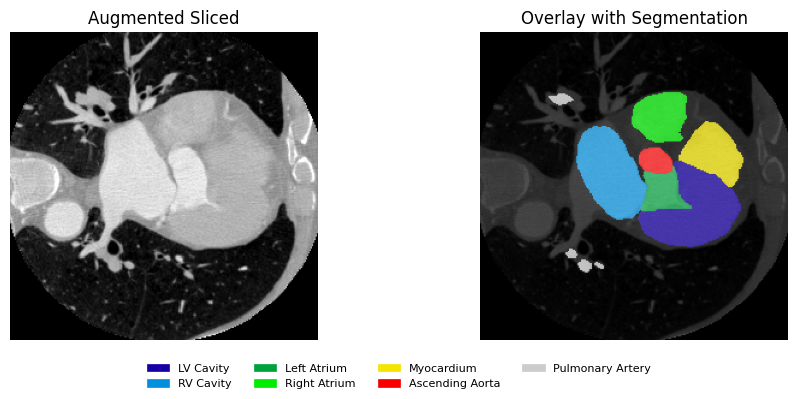

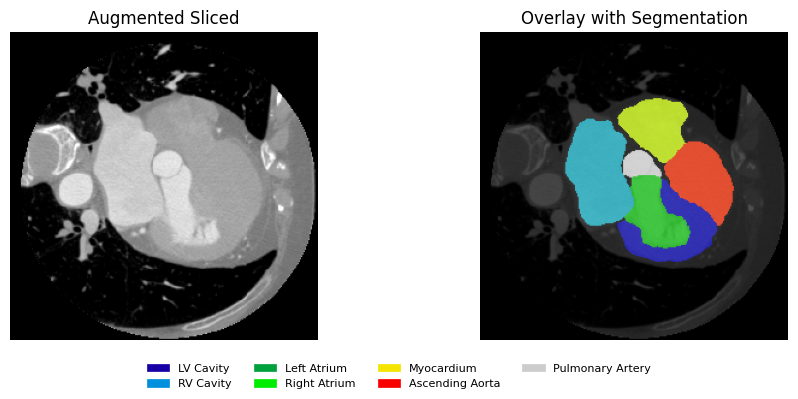

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import torch
import random
label_map = {
    1: "LV Cavity",
    2: "RV Cavity",
    3: "Left Atrium",
    4: "Right Atrium",
    5: "Myocardium",
    6: "Ascending Aorta",
    7: "Pulmonary Artery",
}

def denormalize_image(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def visualize_augmented_samples(dataset, num_samples=2):
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        image_tensor, label_tensor = dataset[idx]

        image_np = image_tensor.numpy()
        label_np = label_tensor.numpy()

        center_slice = denormalize_image(image_np[1])

        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(center_slice, cmap='gray')
        axs[0].set_title("Augmented Sliced")
        axs[0].axis('off')

        axs[1].imshow(center_slice, cmap='gray')
        axs[1].imshow(label_np, cmap='nipy_spectral', alpha=0.7)
        axs[1].set_title("Overlay with Segmentation")
        axs[1].axis('off')

        cmap = plt.get_cmap("nipy_spectral")
        handles = [
            mpatches.Patch(
                color=cmap(cls / len(label_map)),
                label=label,
                edgecolor='black',
                linewidth=0.5
            )
            for cls, label in label_map.items()
        ]
        fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=8, handlelength=2)

        plt.tight_layout(rect=[0, 0.1, 1, 1])
        plt.show()

npz_dir = '/content/npz_dataset/pack/processed_data/ct_256/train/npz'
aug_dataset = AugmentedStackedDataset(npz_dir)
visualize_augmented_samples(aug_dataset, num_samples=2)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

class DecoderBlockLinkNetStudent(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 4, 2, 1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.deconv2(x)))
        x = self.relu(self.norm3(self.conv3(x)))
        return x

class RAUNetStudent(nn.Module):
    def __init__(self, num_classes=8, num_channels=3):
        super().__init__()
        self.num_classes = num_classes
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.firstconv = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.firstbn = resnet.bn1
        self.firstrelu = nn.GELU()
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        filters = [64, 128, 256, 512]
        self.decoder4 = DecoderBlockLinkNetStudent(filters[3], filters[2])
        self.decoder3 = DecoderBlockLinkNetStudent(filters[2], filters[1])
        self.decoder2 = DecoderBlockLinkNetStudent(filters[1], filters[0])
        self.decoder1 = DecoderBlockLinkNetStudent(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU()
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU()
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4)
        d3 = self.decoder3(d4)
        d2 = self.decoder2(d3)
        d1 = self.decoder1(d2)

        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        return F.log_softmax(f5, dim=1), d2, d3

In [9]:
class FocalNLLLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        probs = torch.exp(inputs)
        targets = targets.unsqueeze(1)
        probs = torch.gather(probs, 1, targets).squeeze(1)
        focal_factor = (1 - probs) ** self.gamma
        loss = F.nll_loss(inputs, targets.squeeze(1), weight=self.weight, reduction='none')
        return (focal_factor * loss).mean()

class CELDiceFocal(nn.Module):
    def __init__(self, dice_weight=0.5, num_classes=8, gamma=2.0):
        super(CELDiceFocal, self).__init__()
        class_weights = torch.tensor([0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda()
        self.ce = FocalNLLLoss(gamma=gamma, weight=class_weights)
        self.dice_weight = dice_weight
        self.num_classes = num_classes

    def forward(self, outputs, targets):
        ce_loss = self.ce(outputs, targets)
        dice_loss = self.multi_class_dice_loss(outputs, targets)
        total_loss = (1 - self.dice_weight) * ce_loss + self.dice_weight * dice_loss
        return total_loss

    def multi_class_dice_loss(self, outputs, targets, eps=1e-6):
        probs = torch.exp(outputs)
        targets_one_hot = torch.nn.functional.one_hot(targets, self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = torch.sum(probs * targets_one_hot, dims)
        cardinality = torch.sum(probs + targets_one_hot, dims)
        dice = (2. * intersection + eps) / (cardinality + eps)
        return 1 - dice.mean()

In [10]:
import numpy as np
import torch
import tqdm
import math
from torch import nn

def val_multi(model: nn.Module, criterion, valid_loader, num_classes, batch_size, device_ids, ignore_index=0):
    with torch.no_grad():
        model.eval()
        losses = []
        confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
        dt_size = len(valid_loader.dataset)
        tq = tqdm.tqdm(total=math.ceil(dt_size / batch_size))
        tq.set_description('Validation')

        for inputs, targets in valid_loader:
            inputs = inputs.cuda(device_ids[0])
            targets = targets.long().cuda(device_ids[0])
            logits, _, _ = model(inputs)

            loss = criterion(logits, targets)
            losses.append(loss.item())

            preds = logits.data.cpu().numpy().argmax(axis=1)
            targets_np = targets.data.cpu().numpy()

            confusion_matrix += calculate_confusion_matrix_from_arrays(
                preds, targets_np, num_classes
            )
            tq.update(1)
        tq.close()

        if ignore_index is not None:
            confusion_matrix[ignore_index, :] = 0
            confusion_matrix[:, ignore_index] = 0

        valid_loss = np.mean(losses)
        ious = calculate_iou(confusion_matrix)
        dices = calculate_dice(confusion_matrix)

        avg_iou = np.mean(ious)
        avg_dice = np.mean(dices)

        print(f"\nValidation Loss: {valid_loss:.4f}")
        print(f"Average IoU: {avg_iou:.4f}")
        print(f"Average Dice: {avg_dice:.4f}")

        return avg_dice, avg_iou, dices


def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((ground_truth.flatten(), prediction.flatten())).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    return confusion_matrix.astype(np.uint32)


def calculate_iou(confusion_matrix):
    ious = []
    for index in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[index, index]
        fp = confusion_matrix[:, index].sum() - tp
        fn = confusion_matrix[index, :].sum() - tp
        denom = tp + fp + fn
        iou = float(tp) / denom if denom else 0
        ious.append(iou)
    return ious


def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[index, index]
        fp = confusion_matrix[:, index].sum() - tp
        fn = confusion_matrix[index, :].sum() - tp
        denom = 2 * tp + fp + fn
        dice = 2 * float(tp) / denom if denom else 0
        dices.append(dice)
    return dices

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


[Epoch 1/20] Loss: 0.6960


Validation: 100%|██████████| 24/24 [00:03<00:00,  6.72it/s]


Validation Loss: 0.6378
Average IoU: 0.0000
Average Dice: 0.0000


[Epoch 2/20] Loss: 0.6054


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.58it/s]


Validation Loss: 0.6344
Average IoU: 0.0282
Average Dice: 0.0460


[Epoch 3/20] Loss: 0.5544


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.71it/s]


Validation Loss: 0.5853
Average IoU: 0.2181
Average Dice: 0.3207


[Epoch 4/20] Loss: 0.3621


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.66it/s]


Validation Loss: 0.4816
Average IoU: 0.5385
Average Dice: 0.6551


[Epoch 5/20] Loss: 0.1737


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.51it/s]


Validation Loss: 0.4516
Average IoU: 0.6479
Average Dice: 0.7392


[Epoch 6/20] Loss: 0.1053


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.61it/s]


Validation Loss: 0.4410
Average IoU: 0.6835
Average Dice: 0.7642


[Epoch 7/20] Loss: 0.0884


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.61it/s]


Validation Loss: 0.4453
Average IoU: 0.6733
Average Dice: 0.7581


[Epoch 8/20] Loss: 0.0783


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.64it/s]


Validation Loss: 0.4446
Average IoU: 0.6944
Average Dice: 0.7710


[Epoch 9/20] Loss: 0.0743


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.60it/s]


Validation Loss: 0.4443
Average IoU: 0.6935
Average Dice: 0.7704


[Epoch 10/20] Loss: 0.0685


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.59it/s]



Validation Loss: 0.4299
Average IoU: 0.7229
Average Dice: 0.7889
[Epoch 11/20] Loss: 0.0643


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.54it/s]


Validation Loss: 0.4315
Average IoU: 0.7153
Average Dice: 0.7837


[Epoch 12/20] Loss: 0.0625


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.52it/s]


Validation Loss: 0.4393
Average IoU: 0.7184
Average Dice: 0.7862


[Epoch 13/20] Loss: 0.0594


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.54it/s]


Validation Loss: 0.4384
Average IoU: 0.7210
Average Dice: 0.7877


[Epoch 14/20] Loss: 0.0576


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.58it/s]


Validation Loss: 0.4343
Average IoU: 0.7179
Average Dice: 0.7852


[Epoch 15/20] Loss: 0.0503


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.4269
Average IoU: 0.7343
Average Dice: 0.7955


[Epoch 16/20] Loss: 0.0472


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.62it/s]


Validation Loss: 0.4309
Average IoU: 0.7360
Average Dice: 0.7957


[Epoch 17/20] Loss: 0.0466


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.56it/s]


Validation Loss: 0.4265
Average IoU: 0.7401
Average Dice: 0.7988


[Epoch 18/20] Loss: 0.0450


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.58it/s]


Validation Loss: 0.4296
Average IoU: 0.7374
Average Dice: 0.7970


[Epoch 19/20] Loss: 0.0440


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s]


Validation Loss: 0.4269
Average IoU: 0.7386
Average Dice: 0.7979


[Epoch 20/20] Loss: 0.0430


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.40it/s]



Validation Loss: 0.4280
Average IoU: 0.7405
Average Dice: 0.7990


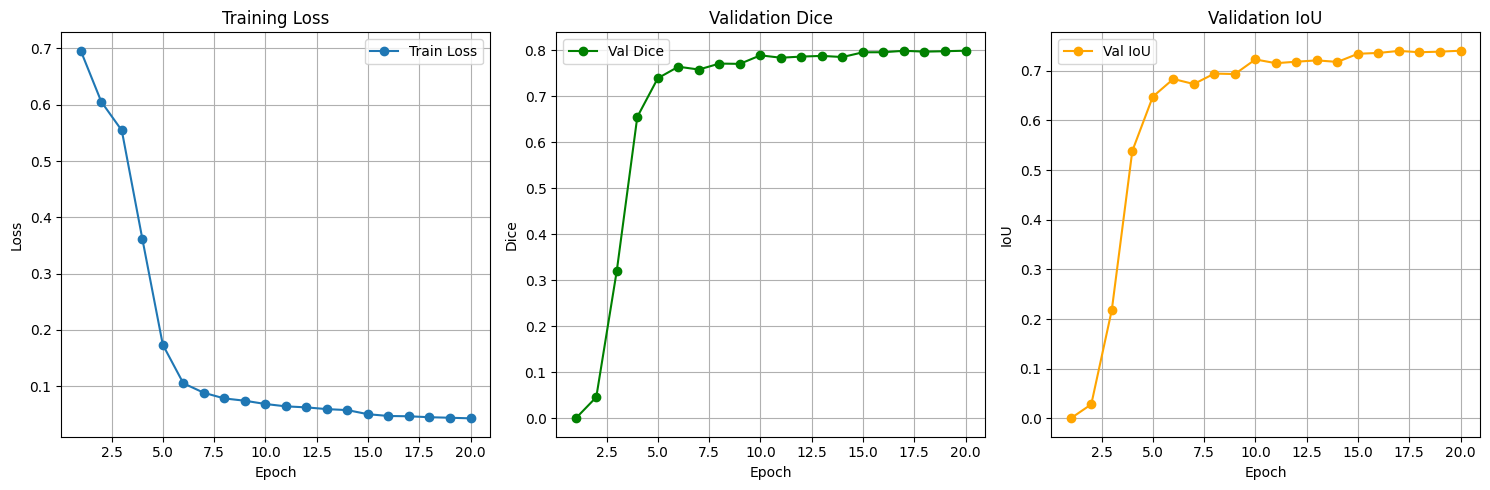


Final Per-Class Dice Evaluation


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.50it/s]


Validation Loss: 0.4280
Average IoU: 0.7405
Average Dice: 0.7990

Per-Class Dice Scores:
  Background          : Dice = 0.0000
  LV                  : Dice = 0.7827
  RV                  : Dice = 0.9665
  LA                  : Dice = 0.8542
  RA                  : Dice = 0.9671
  Myocardium          : Dice = 0.9306
  Aorta               : Dice = 0.9609
  Pulmonary Artery    : Dice = 0.9298


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dir = '/content/npz_dataset/pack/processed_data/ct_256/train/npz'
val_dir = '/content/npz_dataset/pack/processed_data/ct_256/val/npz'


num_classes = 8
batch_size = 16
lr = 1e-4
num_epochs = 20

train_dataset = AugmentedStackedDataset(train_dir)
val_dataset = StackedSliceDataset(val_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = RAUNetStudent(num_classes=num_classes, num_channels=3).cuda()

criterion = CELDiceFocal(dice_weight=0.7, num_classes=num_classes)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

train_losses, val_dices, val_ious = [], [], []

# Training
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []

    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()

        optimizer.zero_grad()
        logits, _, _ = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    dice, iou, _ = val_multi(model, criterion, val_loader, num_classes, batch_size, [0], ignore_index=0)
    val_dices.append(dice)
    val_ious.append(iou)
    scheduler.step(dice)

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ct_teacher_epoch{epoch+1}.pth")

# Plotting
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_dices, marker='o', color='green', label='Val Dice')
plt.title("Validation Dice")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.grid(True); plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_ious, marker='o', color='orange', label='Val IoU')
plt.title("Validation IoU")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# Final Evaluation with Per-Class Dice
print("\nFinal Per-Class Dice Evaluation")
_, _, per_class_dices = val_multi(model, criterion, val_loader, num_classes, batch_size, [0], ignore_index=0)

label_names = [
    "Background", "LV", "RV", "LA", "RA", "Myocardium", "Aorta", "Pulmonary Artery"
]

print("\nPer-Class Dice Scores:")
for i, score in enumerate(per_class_dices):
    print(f"  {label_names[i]:<20}: Dice = {score:.4f}")

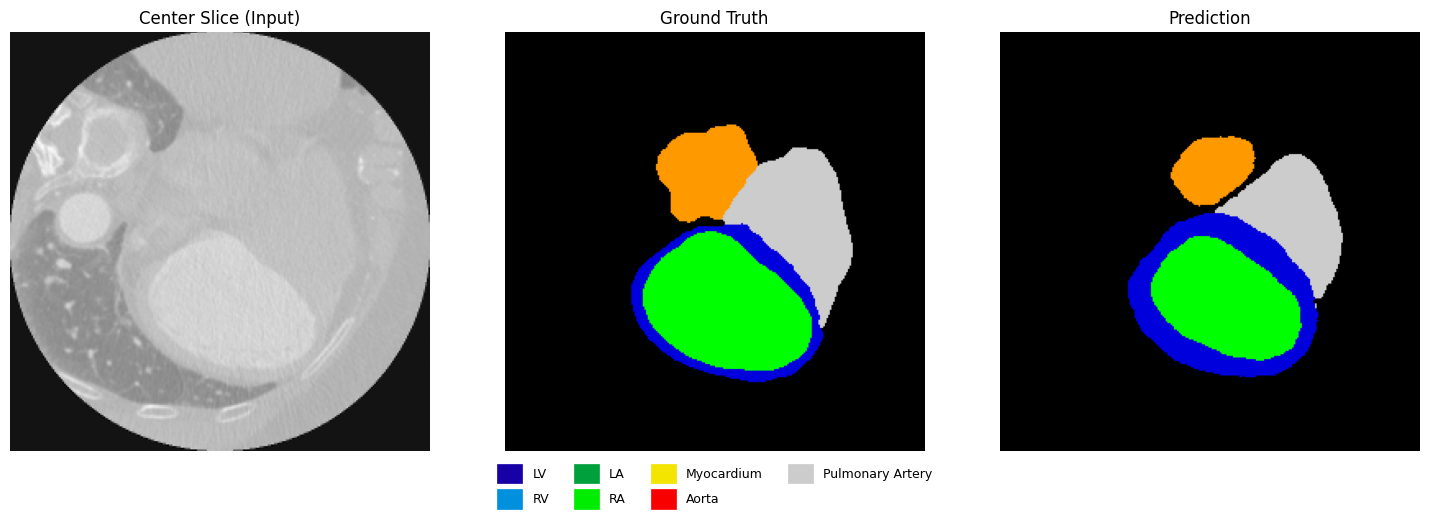

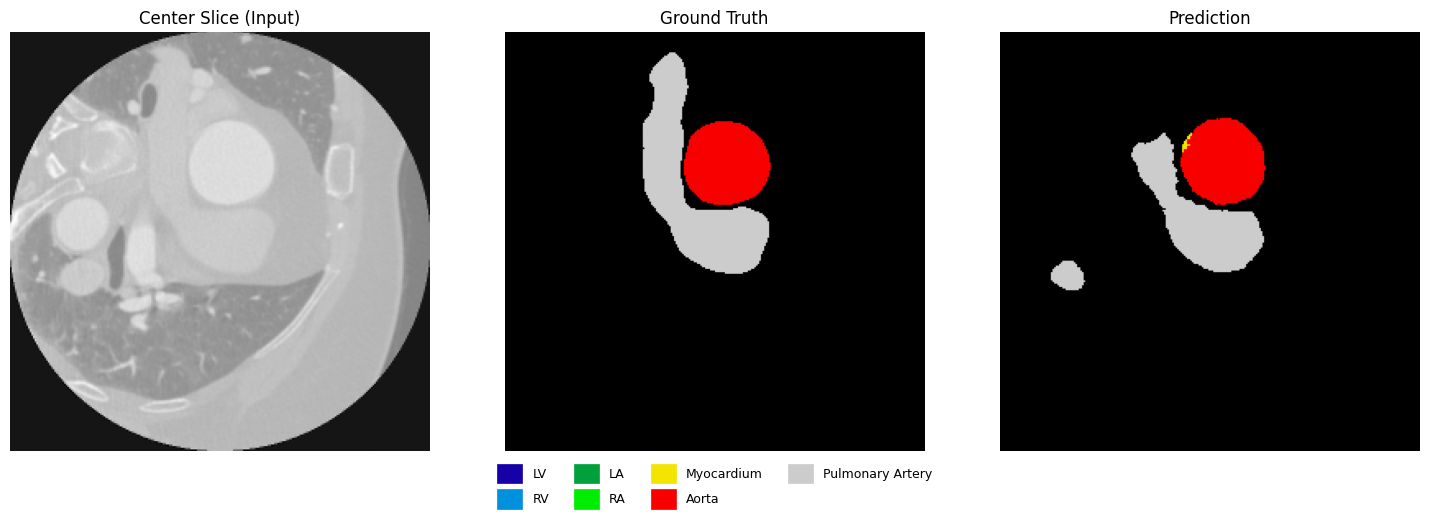

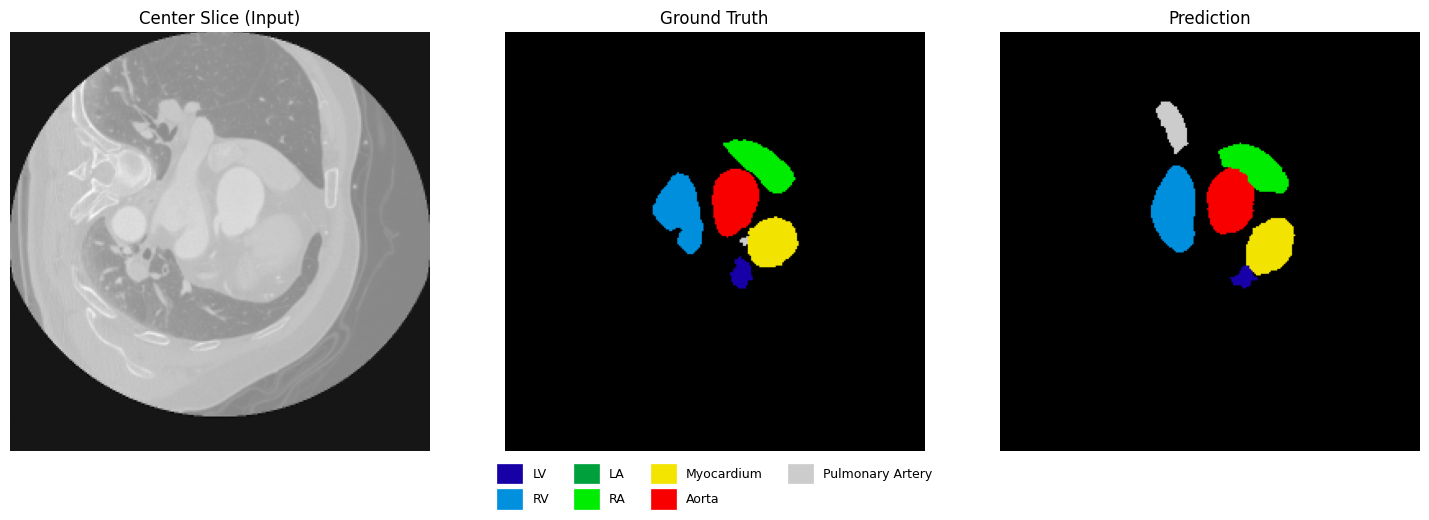

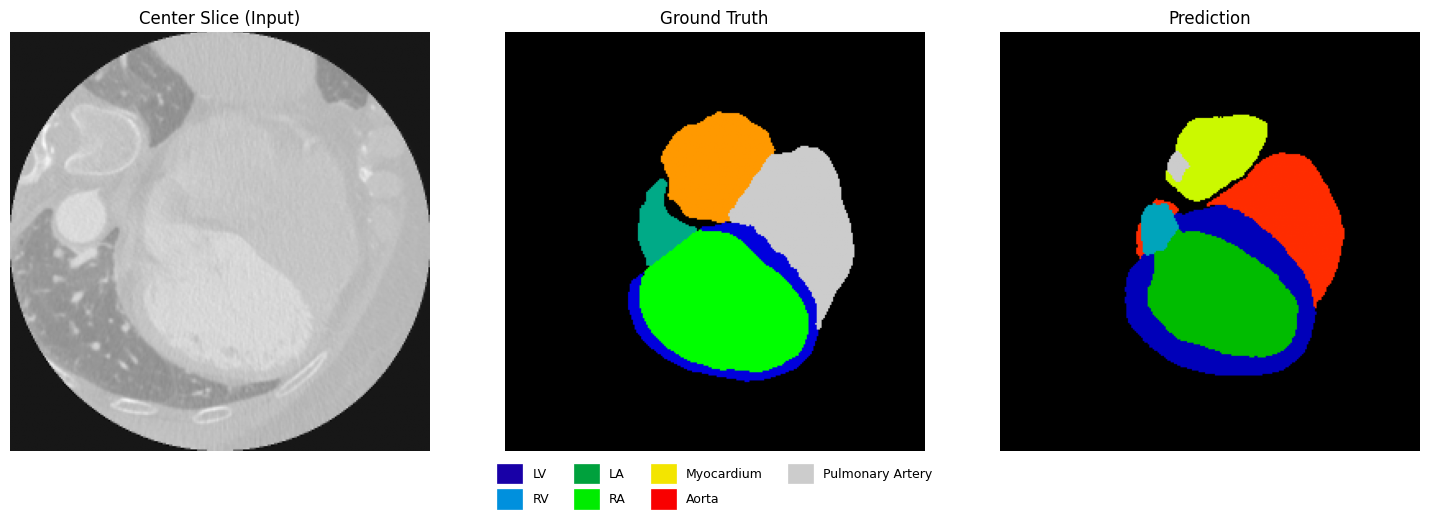

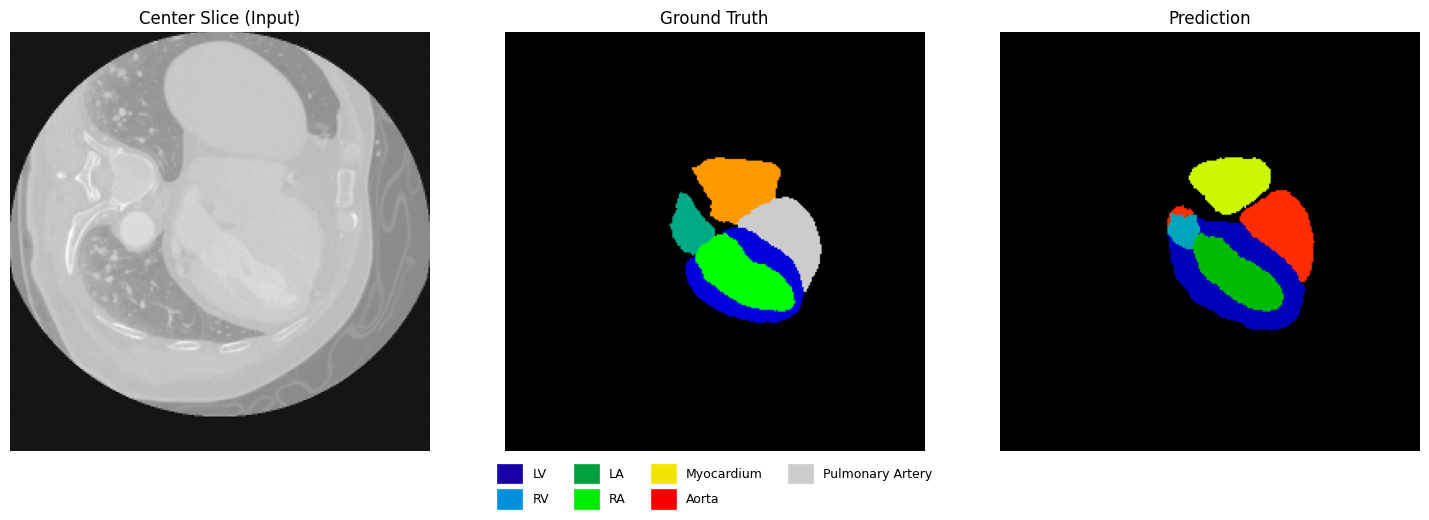

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as F
import random

model.eval()

label_map = {
    1: "LV",
    2: "RV",
    3: "LA",
    4: "RA",
    5: "Myocardium",
    6: "Aorta",
    7: "Pulmonary Artery"
}

val_samples = list(val_dataset)
num_to_show = 5

random_indices = random.sample(range(len(val_samples)), num_to_show)

for idx in random_indices:
    image, mask = val_dataset[idx]
    input_tensor = image.unsqueeze(0).cuda()

    with torch.no_grad():
        logits, _, _ = model(input_tensor)
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1).squeeze().cpu().numpy()

    input_center = image[1].cpu().numpy()
    gt = mask.numpy()

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_center, cmap='gray')
    axs[0].set_title("Center Slice (Input)")
    axs[0].axis('off')

    axs[1].imshow(gt, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred, cmap='nipy_spectral')
    axs[2].set_title("Prediction")
    axs[2].axis('off')

    cmap = plt.get_cmap("nipy_spectral")
    handles = [
        mpatches.Patch(
            color=cmap(cls / len(label_map)),
            label=name,
            linewidth=0.5
        )
        for cls, name in label_map.items()
    ]
    fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=9, handleheight=2, handlelength=2)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

Test Inference: 100%|██████████| 31/31 [00:08<00:00,  3.56it/s]



Per-Class Dice Scores (Test Set):
  LV                  : Dice = 0.7788
  RV                  : Dice = 0.8590
  LA                  : Dice = 0.7460
  RA                  : Dice = 0.7097
  Myocardium          : Dice = 0.7913
  Aorta               : Dice = 0.7214
  Pulmonary Artery    : Dice = 0.5767

Average Dice Score on Test Set: 0.7396


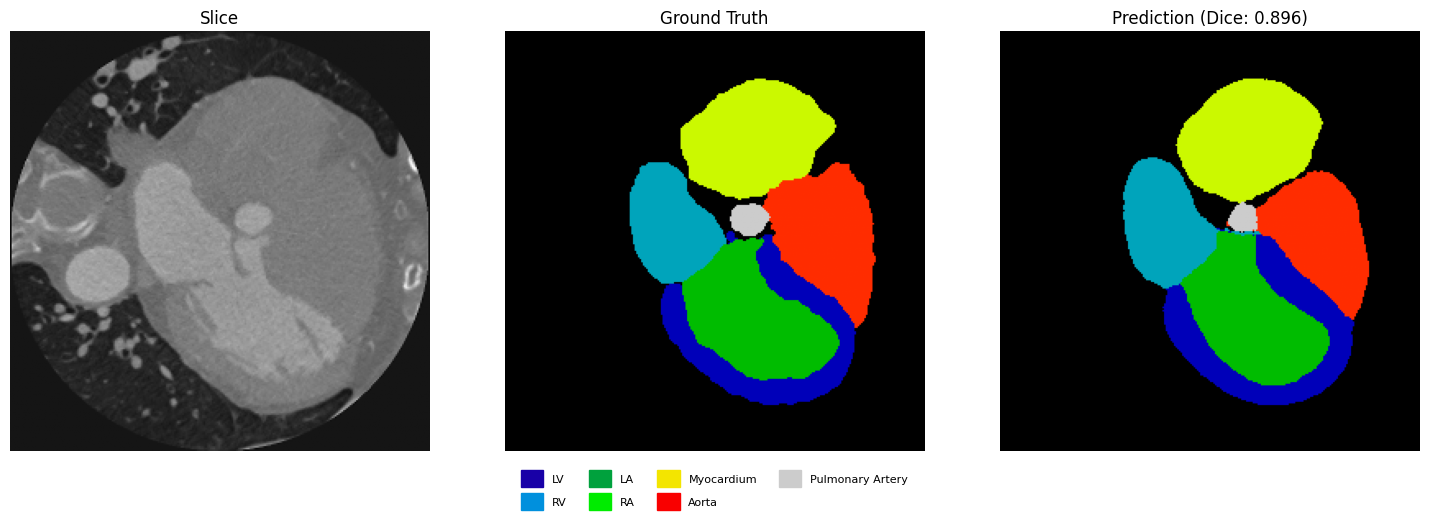

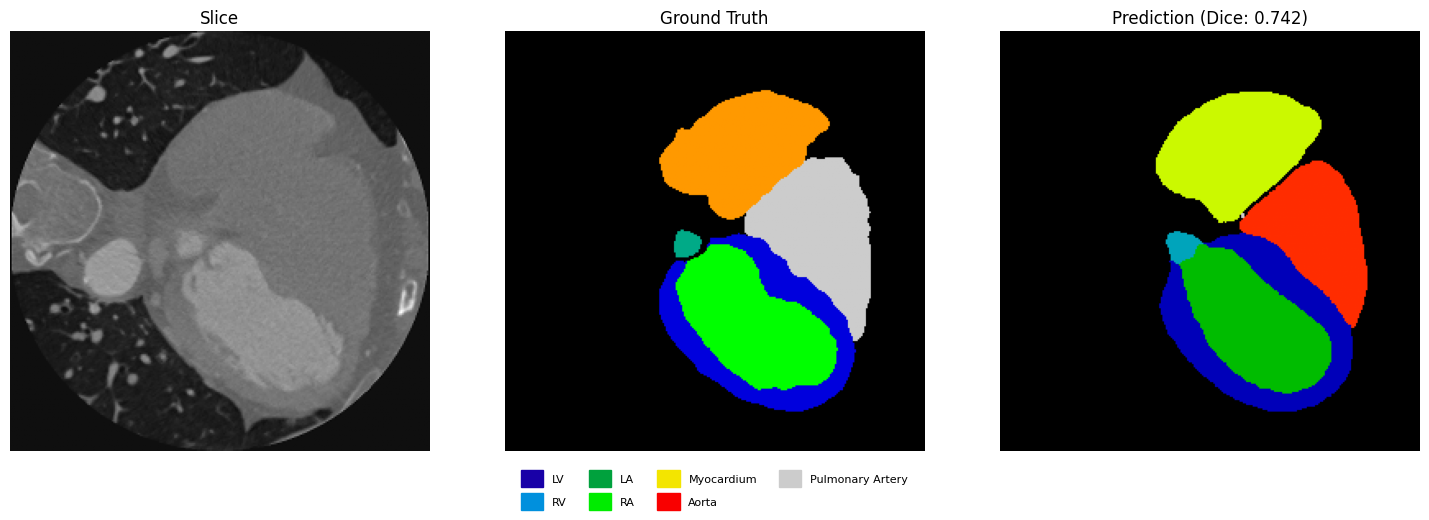

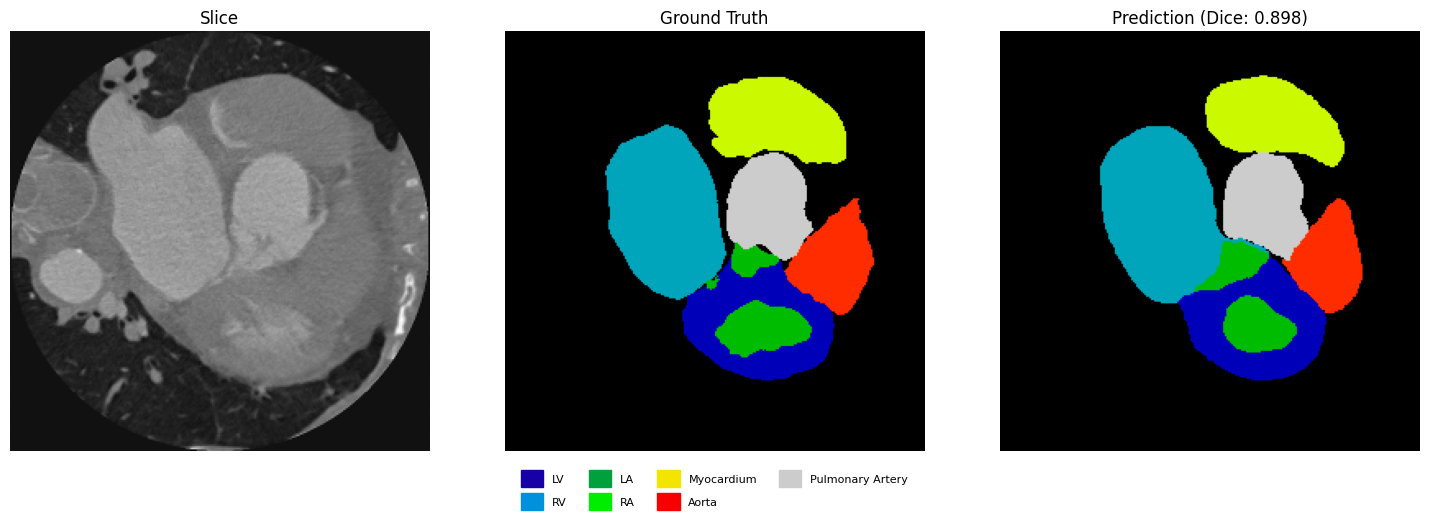

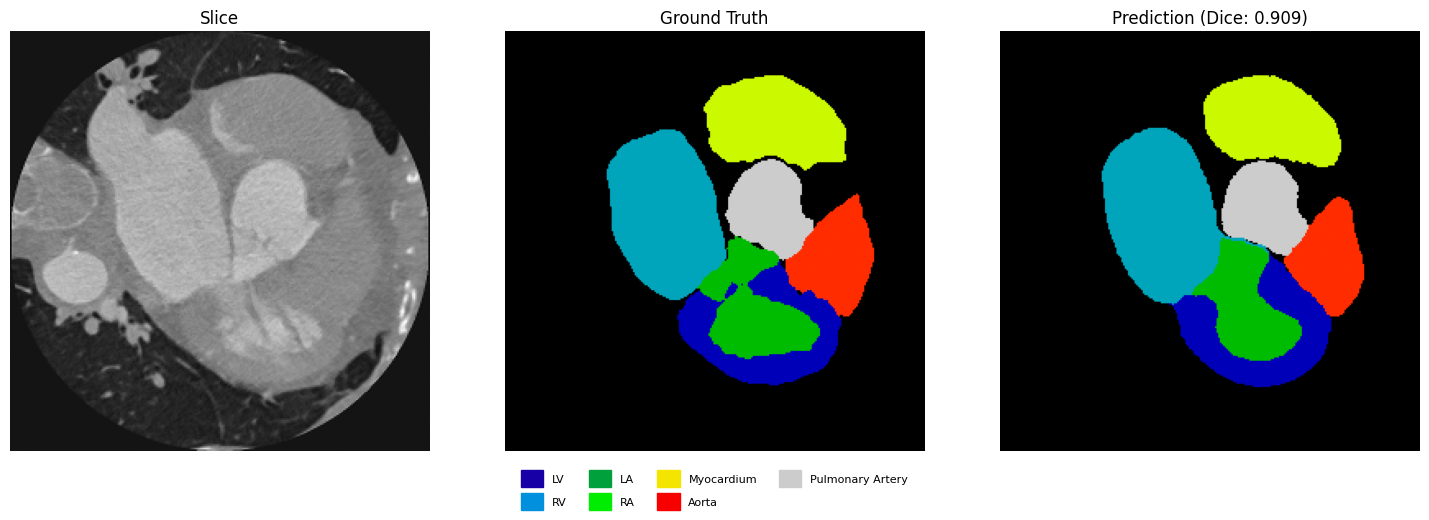

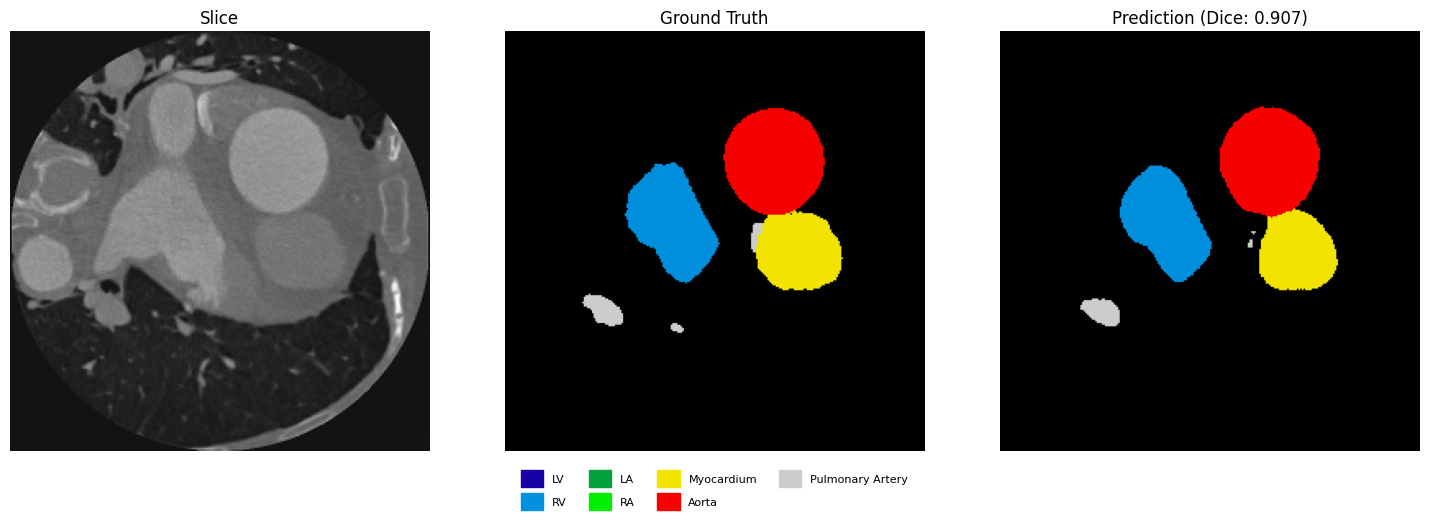

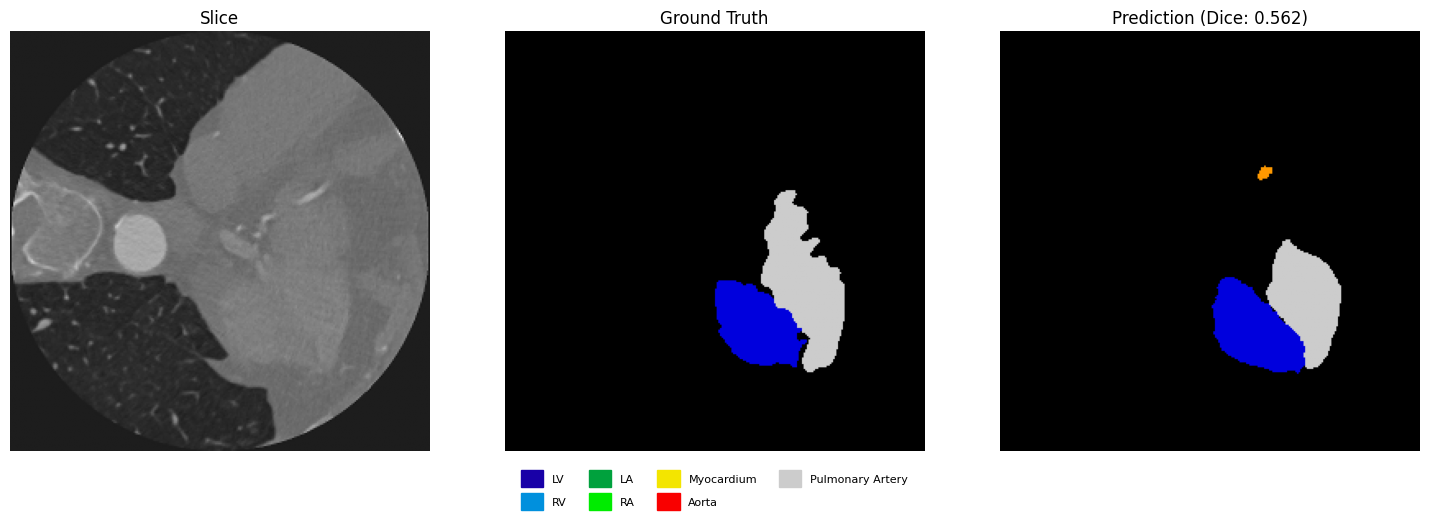

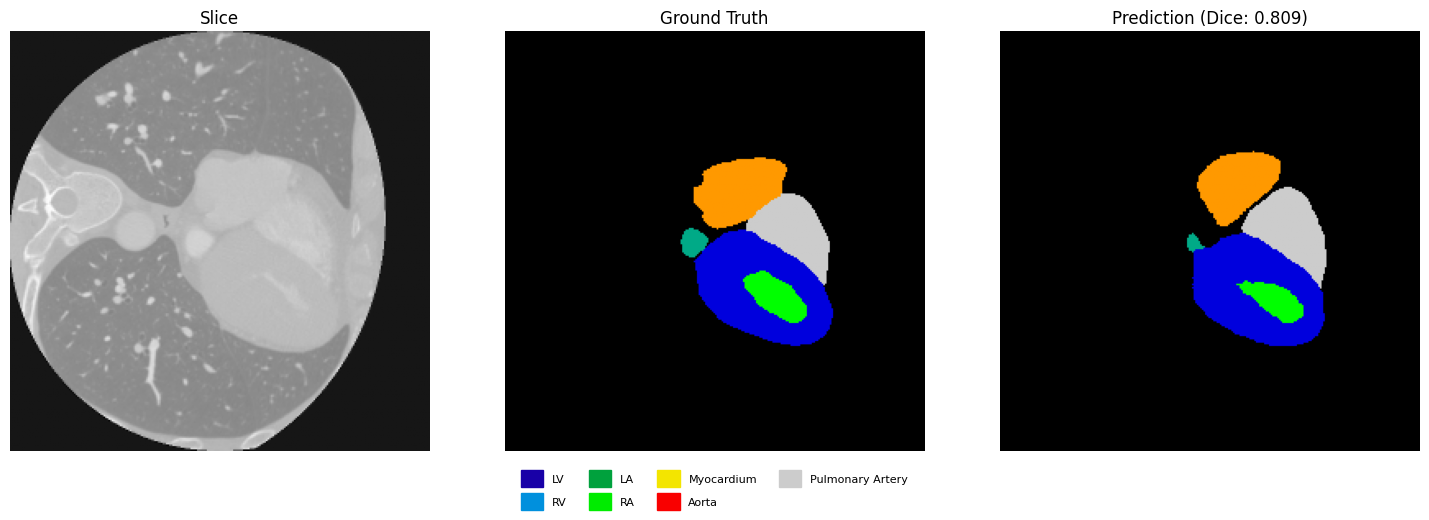

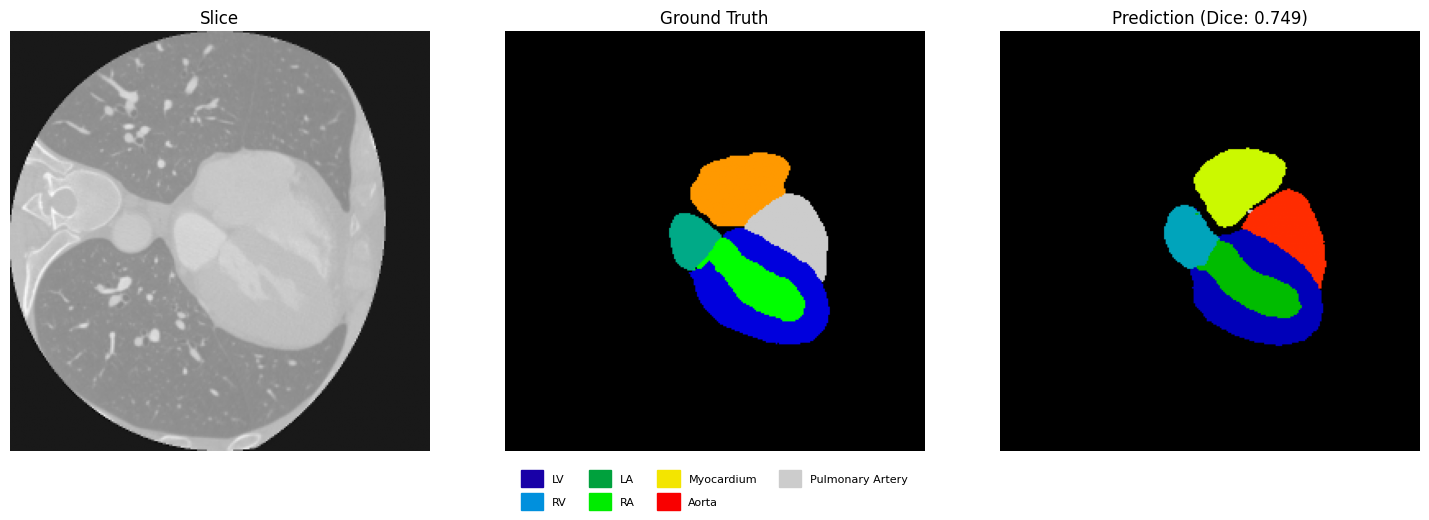

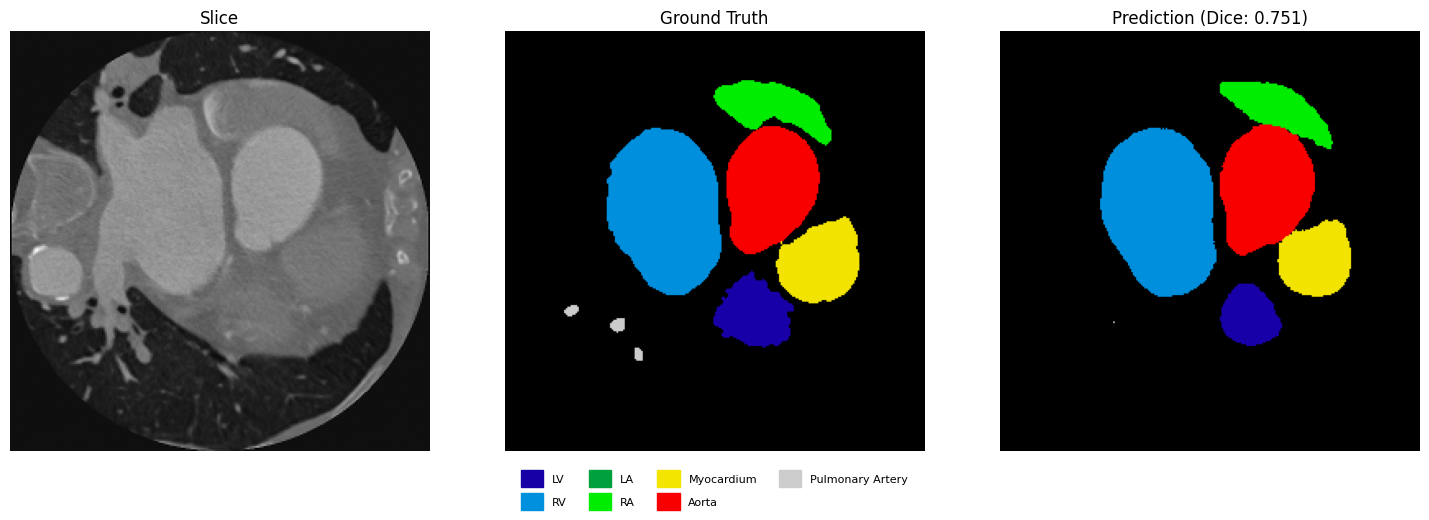

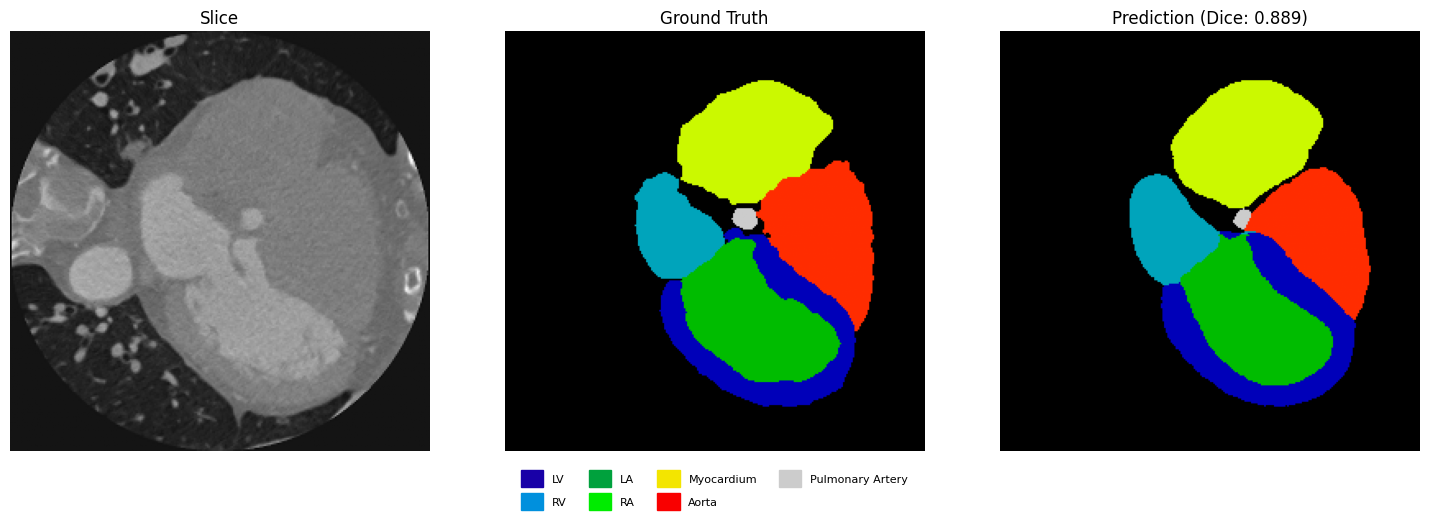

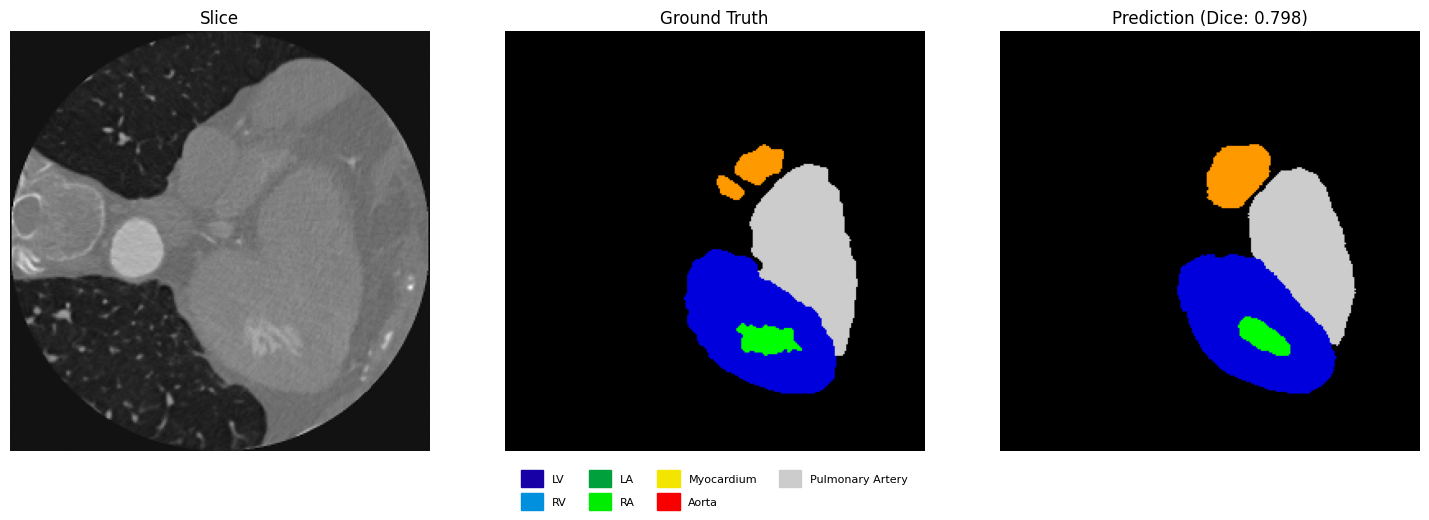

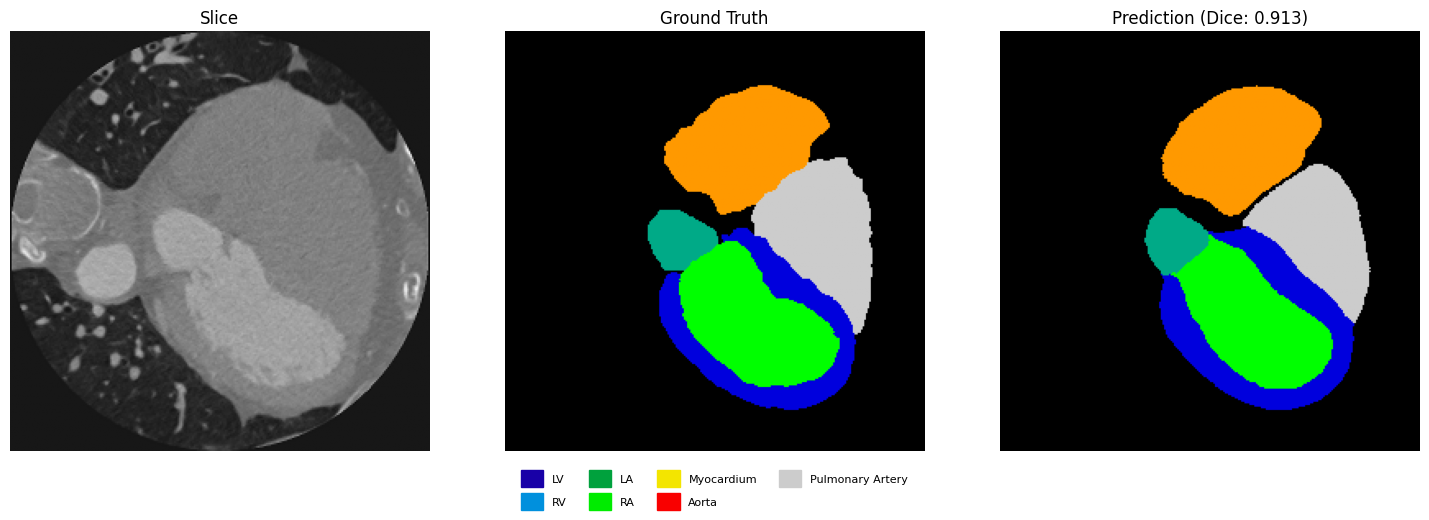

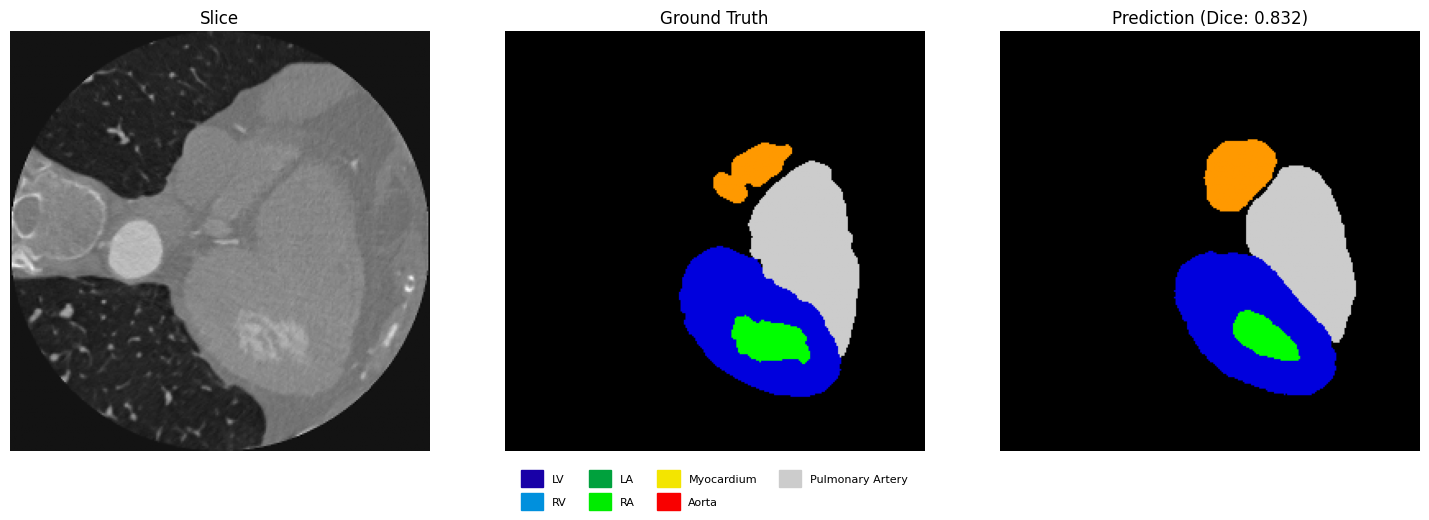

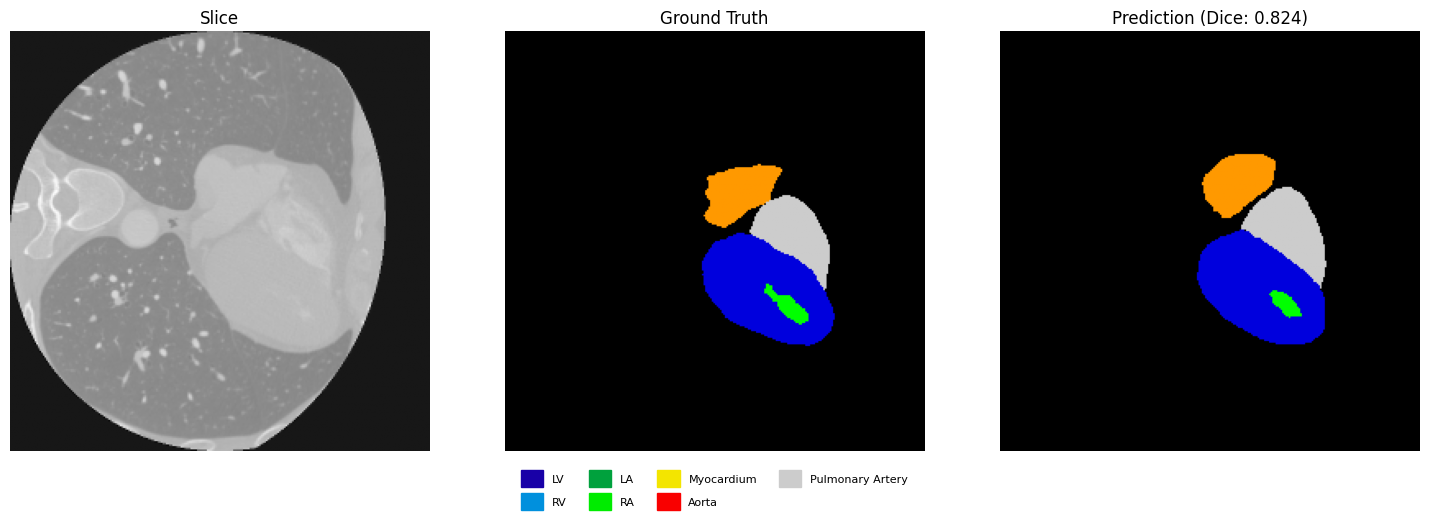

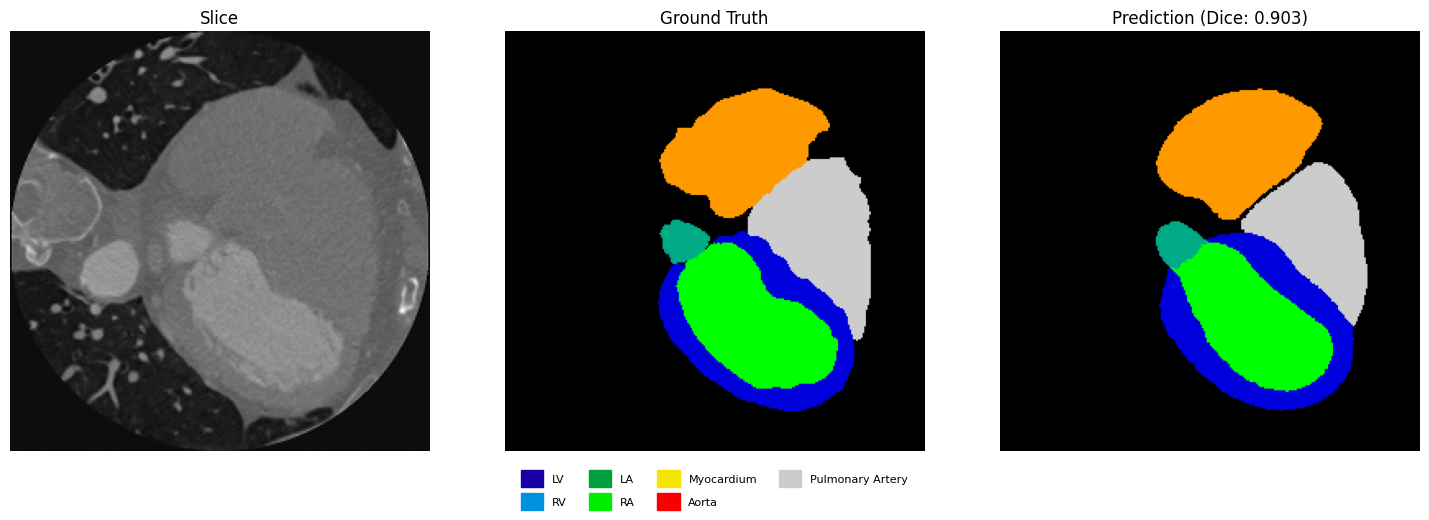

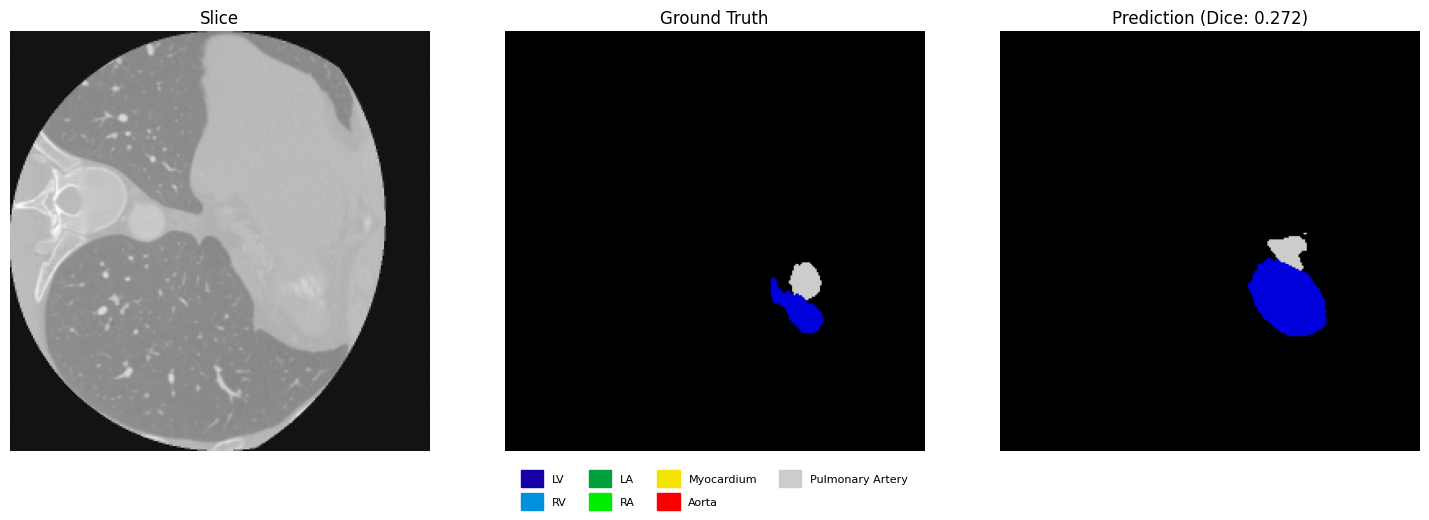

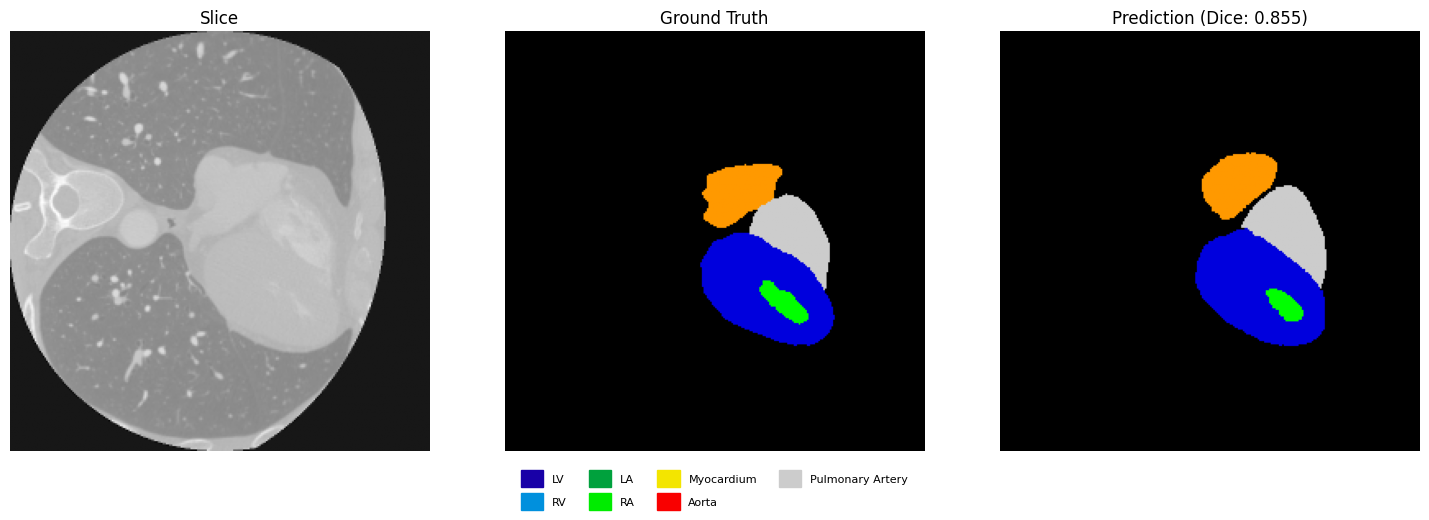

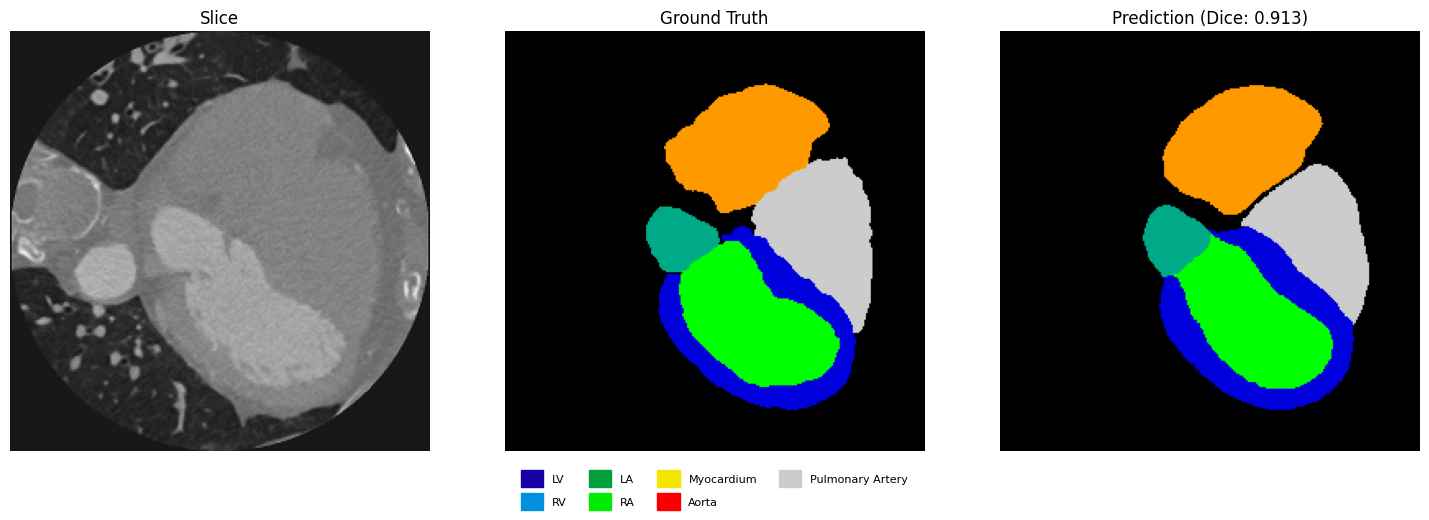

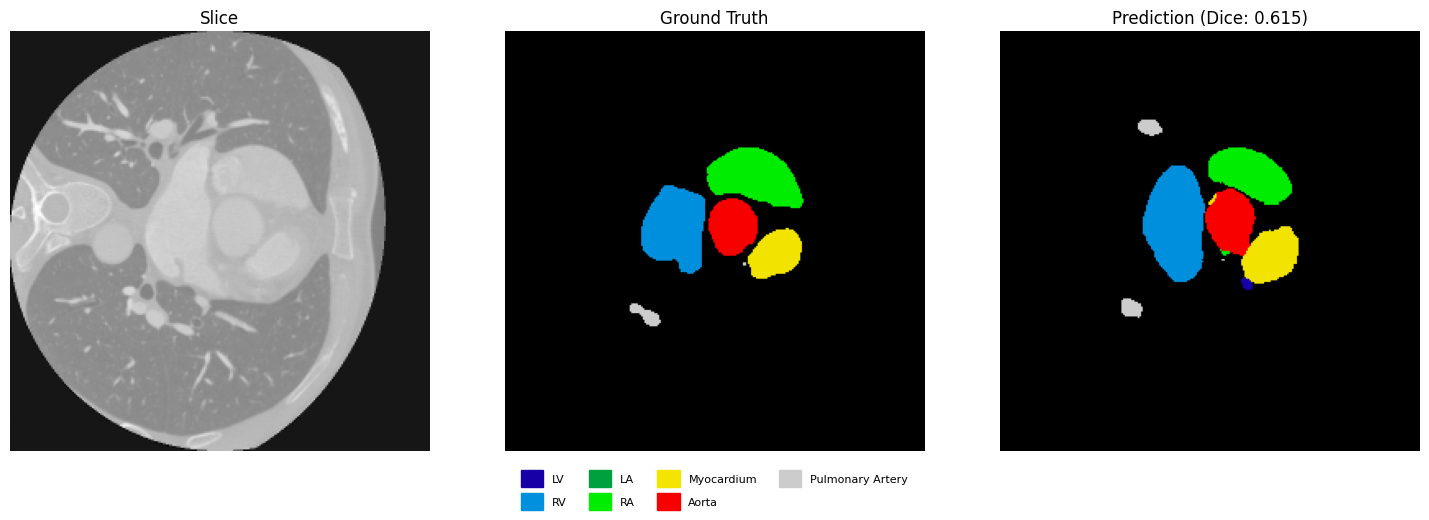

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import matplotlib.patches as mpatches

test_dir = '/content/npz_dataset/pack/processed_data/ct_256/test/npz'
weights_path = 'ct_teacher_epoch20.pth'
num_classes = 8
batch_size = 16
num_to_visualize = 20

label_names = [
    "Background", "LV", "RV", "LA", "RA", "Myocardium", "Aorta", "Pulmonary Artery"
]

model = RAUNetStudent(num_classes=num_classes, num_channels=3)
model.load_state_dict(torch.load(weights_path, map_location='cuda:0'))
model = model.cuda()
model.eval()

test_dataset = StackedSliceDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def compute_dice_per_class(pred, target, num_classes):
    dices = []
    for cls in range(num_classes):
        pred_bin = (pred == cls).astype(np.uint8)
        target_bin = (target == cls).astype(np.uint8)
        intersection = np.sum(pred_bin * target_bin)
        union = np.sum(pred_bin) + np.sum(target_bin)
        dice = 2 * intersection / union if union > 0 else np.nan
        dices.append(dice)
    return dices

dice_scores_all = []
class_wise_dices = [[] for _ in range(num_classes)]
all_preds, all_gts = [], []

for images, masks in tqdm(test_loader, desc="Test Inference"):
    images = images.cuda()
    masks = masks.cuda()

    with torch.no_grad():
        logits, _, _ = model(images)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    for pred, gt in zip(preds.cpu().numpy(), masks.cpu().numpy()):
        dices = compute_dice_per_class(pred, gt, num_classes)
        for cls in range(num_classes):
            if not np.isnan(dices[cls]):
                class_wise_dices[cls].append(dices[cls])
        dice_scores_all.append(np.nanmean(dices[1:]))
        all_preds.append(pred)
        all_gts.append(gt)

print("\nPer-Class Dice Scores (Test Set):")
for i in range(1, num_classes):
    if len(class_wise_dices[i]):
        avg = np.mean(class_wise_dices[i])
        print(f"  {label_names[i]:<20}: Dice = {avg:.4f}")
    else:
        print(f"  {label_names[i]:<20}: Dice = N/A")

print(f"\nAverage Dice Score on Test Set: {np.nanmean(dice_scores_all):.4f}")

label_map = {
    1: "LV", 2: "RV", 3: "LA", 4: "RA", 5: "Myocardium", 6: "Aorta", 7: "Pulmonary Artery"
}

sample_indices = random.sample(range(len(all_preds)), num_to_visualize)

for idx in sample_indices:
    input_tensor, _ = test_dataset[idx]
    input_center = input_tensor[1].numpy()  # Middle slice

    pred = all_preds[idx]
    gt = all_gts[idx]
    dice = np.nanmean(compute_dice_per_class(pred, gt, num_classes)[1:])

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_center, cmap='gray')
    axs[0].set_title("Slice")
    axs[0].axis('off')

    axs[1].imshow(gt, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred, cmap='nipy_spectral')
    axs[2].set_title(f"Prediction (Dice: {dice:.3f})")
    axs[2].axis('off')

    cmap = plt.get_cmap("nipy_spectral")
    handles = [
        mpatches.Patch(color=cmap(cls / len(label_map)), label=name)
        for cls, name in label_map.items()
    ]
    fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=8, handleheight=2, handlelength=2)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()